# Projeto 3 – Parsing web em cluster
## Super Computação - 2018/2
### Gabriela Almeida

Para o terceiro projeto de super computação expandiu-se o trabalho feito no projeto 2 para rodar em um cluster de máquinas na AWS. O segundo projeto de super computação trabalhou-se com um problema em que concorrência tinha um papel fundamental na obtenção de bom desempenho: download e análise de páginas web. Criou-se um crawler que identifica páginas de produtos em um site de e-commerce e extrai as informações básicas dos produtos. Alguns exemplos são as categorias do site da Magazine Luiza como as seguinte: [DVD Player](https://www.magazineluiza.com.br/dvd-player/tv-e-video/s/et/tvdb/) e [Controle Remoto](https://www.magazineluiza.com.br/controle-remoto/tv-e-video/s/et/cmrt/).

Para demonstra como a concorrência tem um papel fundamental nesse tipo de problema, esse relatório tem como objetivo demostrar o desempenho de um crawler distribuido, organizado em processos, implementado em MPI em um cluster de máquinas na AWS. Esse relatório também apontará a diferença de desempenho entre um crawler sequêncial, um paralelo organizado em threads e esse distribuído.

## Descrição e Implementação do problema

### Modelo sequencial

A implementação do modelo sequencial foi feita da seguinte forma: dada uma página de exibição de produto, o web crawler extrai as seguintes informações

    1. nome do produto
    2. descrição do produto
    3. url da foto do produto
    4. preço à vista 
    5. preço parcelado
    6. categoria do produto
    7. url da página de axibição

A identificação de páginas de produto é feita a partir de sua categoria, ou seja, o crawler desenvolvido é apontado para uma página com os produtos de uma categoria, como os exemplificados anteriormente, e ele consegue obter as páginas de produto, lindando com possíveis paginação da listagem.

Após a compilação do programa, explicado no README, o programa é executado na linha de comando como:

    ./crawlerSEQ url_da_listagem_por_categoria

A partir dessa url disponibilizada, o programa faz o download do conteúdo html dessa página, usando a biblioteca _curl_: 

Com o html da página de categoria disponível, é possível adquirir as urls dos produtos presentes nela e a da página seguinte a ela. Para fazer isso, usou-se o regex da biblioteca boost. Essa ferramenta se baseia em expressões regulares para identificação de strings.

Sendo possível adquirir todas as urls das páginas de produtos da categoria ,além das url dos produtos dessas páginas, então é possível fazer o download das páginas de todos os produtos e obter as informações desejadas.

O resultado do programa é escrito na saída padrão no formato json. Cada produto é um objeto com os seguintes campos:

    {
        "nome": "",
        "descricao": "",
        "foto": "",
        "preco: 0,
        "preco_parcelado": 0,
        "preco_num_parcelas": 0,
        "categoria": "",
        "url": """
    }

### Modeleo distribuído

A implementação do modelo paralelo possui uma lógica parecida com a do sequencial. Assim como o modelo anterior, é feito download da página com os produtos, são identificadas as urls dos produtos presentes nela e a url da página seguinte, é feito o download das paginas dos produtos, extraídas as informações necessárias e após a análise de todos os produtos faz-se o mesmo processo com a página seguinte.

No entanto essa implementação é feita a partir de sistemas com memória distribuída, ou seja, são disparados vários processos em máquinas de um cluster e esses são sincronizados a partide de troca de mensagens entre eles.

Assim como no sequencial, após a compilação do programa, explicado no README, o programa é executado na linha de comando como:



    mpiexec -n p -hostfiles hosts ./crawlerDIS url_da_listagem_por_categoria

Onde *p* é o número de processos e hosts um arquivo informando os ips das máquinas do cluster que rodaram o programa. Caso queira rodar em somente uma máquina, como em uma local, não coloque essa informação, apenas "mpiexec -n p ./crawlerDIS url_da_listagem_por_categoria"

O modelo distribuido foi estruturado da seguinte forma:

Considerando que existem n processos rodando, o processo de número '0' é o encarregado de receber a url indicada na linha de comando e fazer o download dela. Com a string do código fonte dessa página, resultado desse download, esse processo busca pelas urls desejadas, usando regexs. Com isso ela possui a url da página seguinte e uma lista cujo cada índice é uma string que representa a url de um produto dessa página. Assim o processo 0 distribui as urls dessa lista para os processos que vão de 1 a n-2 em ordem, ou seja, a url[0] vai para o processo 1, a url[1] para o processo 2, a url[2] para o processo[3] e assim por diante. Ao enviar a url[n-3] ao processo n-2 o processo 0 "volta para o início" e entrega a próxima url, url[n-2], para o processo 1, a url[n-1] para o processo 2... Isso acontece até a lista de urls acabar, ou seja, até a url[m-1] for entregue para um processo. Depois disso é feito o download da url da página seguinte e esse processo se repete.

![alt text](EsquemaDIS1.png "Title")

No entanto é preciso adotar também uma estratégia de como informar o fim do processo 0 para esses mesmos processos. Assim, quando não houver mais uma próxima página de produto, o processo 0 enviará para os processos de 1 a n-2 a string de finalização "end".

![alt text](EsquemaDIS2.png "Title")

Como o objetivo desse relatório também é analisar o desempenho do programa é importante apontar como são feitas as trocas de mensagens para que essas medições sejam feitas corretamentes. As medidas levadas em consideração nessa análise serão melhor explicadas na seção "Análise de desempenho", no entanto o que se é preciso saber é que precisa-se calcular o tempo gasto para fazer o download das páginas (tempo ocioso) e o número total de produtos. Esses números são cálculados ao longo do processo 0 e, após enviar a string de finalização aos processos de 1 a n-2, essas variáveis (double tempoOcioso e int numProdTotal) são enviadas ao processo n-1.

![alt text](EsquemaDIS3.png "Title")

Considerendo a estrutura a cima o código do processo '0' possui o seguinte formato:

Os processos de 1 a n-2 são encarregados de receber a url do produto advinda do processo 0 e fazer o download dessa página. Com a string do código fonte dessa página, resultado desse download, esse processo busca pelas informações desejadas, usando regexs. Com isso se é produzido a strign 'out' com as informações do produto no formato json. Essa string é então enviada para o processo n-1.

![alt text](EsquemaDIS4.png "Title")

A estratégia para informar ao processo n-1 que os processos ps acabaram é a mesma adotada anteriormente, caso esse processo receba uma url do produto = "end", significando que não existem mais produtos, o processo p enviará ao processo n-1 a string de finalização "end"

![alt text](EsquemaDIS5.png "Title")

Como no processo anterior, esses processos também calculam o tempo ocioso e, além dessa medida, calculam o tempo gasto em cada produto. No entanto, essa última informação não precisa ser passada para outros processos, somente a primeira (double tempoOcioso) é passada para o processo n-1 após o envio da string de finalização.

![alt text](EsquemaDIS6.png "Title")

Desse modo a estruturação dos processo *p*s (0<p<n-1) tem o seguinte formato:

O processo n-1 é o encarregado de receber as informações vindas dos outros processos e juntá-las tornando-as uma informação completa. Esse processo recebe strings 'out' dos processos de 1 a n-1 e as juntam a uma string jsonFinal. Quando todos os processos enviam a string "end" a string jsonFinal é enviada à saída padrão. 

![alt text](EsquemaDIS7.png "Title")

No entanto, é preciso lembrar que esse processo não recebe somente a string 'out', ele também recebe o double tempoOcioso de todos os outros processos e também receve o int numProdTotal do processo 0. Assim, são feitos algumas mudanças no esquema acima: quando algum processo enviar a string 'end' é preciso receber o tempoOcioso advindo dele e somar esse valor ao double tempoOciosoTotal. Outra mudança é que quando todos os processos *p* tiverem informado o seu fim é preciso receber o int numProdTotal enviado pelo processo 0 e o tempoOcioso enviado pelo mesmo e somar esse valor ao tempoOciosoTotal.

![alt text](EsquemaDIS8.png "Title")

A estrutura do processo n-1 tem então o seguinte formato:

### Modelo paralelo

A implementação do modelo paralelo possui uma lógica parecida com a do sequencial. Assim como o modelo anterior, é feito download da página com os produtos, são identificadas as urls dos produtos presentes nela e a url da página seguinte, é feito o download das paginas dos produtos, extraídas as informações necessárias e após a análise de todos os produtos faz-se o mesmo processo com a página seguinte.

No entanto essa implementação é dada em paralelismo por tarefas, ou seja, é preciso sincronizar tarefas que dependem parcialmente umas das outras (parte de uma tarefa depende de um resultado de outra quanto o restante é independente). Ao exercutar as partes independente de maneira paralela pode-se obter ganhos de desempenho consideráveis em processos longos.

O modelo paralelo por tarefas foi estruturado da seguinte forma:

![alt text](EsquemaPAR1.png "Title")

É possível perceber no esquema a cima que as threads compartilham de alguns recursos fazendo com que elas sejam interdependentes.

A thread prodLinkCollectorThread é encarregada de fazer o download das páginas com os produtos, identificar as urls dos produtos presentes nelas e colocá-las na listofUrls. Além disso essa thread é encarregada de adquirir a url da pagina com produtos seguinte e fazer o mesmo processo, sucessivamente, até a última página dessa categoria. Desse modo, essa thread terá adicionado à listofUrls as urls de todos os produtos disponíveis naquela categoria.
A segunda thread, prodPageCollectorThread, precisa recolher uma url da listofUrls, fazer o download dela e adicionar-la à listofPages. 
Já prodCollectorThread coleta uma pagina de listofPages, coleta as informações desejadas e as adiciona a uma string global "finalJSON".

Levando em consideração essa estruturação, é possível definir multiplas threads do tipo prodPageCollectorThread fazendo com que elas rodem em paralelo.O mesmo pode acontecer com prodCollectorThread.

![alt text](EsquemaPAR2.png "Title")

Como essas threads compartilham algumas estruturas, o uso de semáforos é fundamental para coordenar o acesso de cada thread a elas. Desse modo foram definidos os seguintes semáforos:

O primeiro controla o acesso à listofUrls, o segundo o acesso à listofPages e o tercero o acesso à string global "finalJSON". Já os dois últimos valem como contadores de quantidade de elementos em listofUrls e listofPages respectivamente.

Assim como no sequencial, após a compilação do programa, explicado no README, o programa é executado na linha de comando como:

    ./crawlerPAR url_da_listagem_por_categoria numProducers numConsumers

No qual numProducers é o número de threads do tipo prodPageCollectorThread e numConsumers é o numero de threads do tipo prodCollectorThread.

As threads são definidas da seguinte forma:

## Análise de desempenho

Como dito anteriormente, um dos objetivos desse projeto é comparar o desempenhos entre o crawler distribuido, paralelo e o sequencial. Para fazer essa comparação foi preciso compilar o programa usando as flags correntas. Para o modelo paralelo as seguintes flags foram usadas:

    -lpthread -O2

Para a sequencial a seguinte flag:

    -O2

Para o distribuido as seguintes flags:

    -O2 -lboost_mpi -lboost_serialization

Para fazer essa análise de desempenho, usou-se um cluster na aws com 7 máquinas. O tipo de instância usada nelas é t3.micro cuja especificações são as seguintes:

![alt text](t3MicroSpecif.png "Title")

E as especificações do sistema operacional dessas instâncias são as seguintes:

    Distributor ID:	Ubuntu
    Description:	Ubuntu 18.04.1 LTS
    Release:	18.04
    Codename:	bionic

Para obter os tempos de simulação é preciso executar os seguintes comandos:

    mkdir build
    cd build
    cmake ..
    make
    cd ..
    python3 run.py

Esses comandos compilam os arquivos com cmake e geram 3 executaveis diferentes: crawlerSEQ, crawlerPAR e crawlerDIS. Depois eles são executados com os 4 diferentes links de categorias diferentes, sendo eles: 

* https://www.magazineluiza.com.br/notebook-lenovo-ideapad/informatica/s/in/leip/
* https://www.magazineluiza.com.br/dvd-player/tv-e-video/s/et/tvdb/
* https://www.magazineluiza.com.br/hd-externo/informatica/s/in/hdex/
* https://www.magazineluiza.com.br/adega/eletrodomesticos/s/ed/adeg/

Levando em consideração as especificações das máquinas utilizadas no cluster, optou-se por rodar o crawler paralelo com 3 threads produtoras e 3 threads consumidoras, pois como visto no projeto anterior essa era a configuração mais eficiente para esse cenário.

Já para o crawler distribuído, optou-se por rodar com 4 processos por máquina. Foram feitos testes rodando de 1 a 7 máquinas no cluster.

Para todas essas situações foram medidos o tempo ocioso, que é o tempo total gasto esperando o download de páginas web, o tempo médio por produto, que é o tempo total de execução do programa dividido pelo total de produtos analisados, e tempo total, que é o tempo total de execução do programa.

Por fim, é escrito um arquivo de saída analysis.txt com os valores dos tempos de cada categoria, para cada executável, nas situações descritas a cima, em ordem.

In [152]:
t_num_prod=[33,90,178,216]

t_ocioso_seq=[47.6662,81.5548,305.4,340.358]
t_medProd_seq=[1.51591,0.973464,1.77754,1.63987]
t_total_seq=[50.0249,87.6118,316.402,354.212]

t_ocioso_par_3_3=[58.9774,146.47,281.832,365.421]
t_medProd_par_3_3=[0.684618,0.553316,0.534241,0.566174]
t_total_par_3_3=[22.5924,49.7984,95.0949,122.294]

t_ocioso_dis_1=[60.2152,168.18,333.796,454.519]
t_ocioso_dis_2=[32.0191,90.0839,202.565,269.897]
t_ocioso_dis_3=[23.04,60.1019,159.073,154.469]
t_ocioso_dis_4=[16.9147,49.6238,105.018,124.932]
t_ocioso_dis_5=[11.978,43.2922,77.383,109.053]
t_ocioso_dis_6=[11.0729,37.0383,79.1058,99.3294]
t_ocioso_dis_7=[12.0187,31.753,66.6282,82.9702]

t_medProd_dis_1=[1.09389,1.02553,1.02753,1.10602]
t_medProd_dis_2=[0.375824,0.351161,0.363493,0.393484]
t_medProd_dis_3=[0.24852,0.217793,0.242519,0.209929]
t_medProd_dis_4=[0.172867,0.172247,0.158582,0.151773]
t_medProd_dis_5=[0.102936,0.142198,0.126536,0.115807]
t_medProd_dis_6=[0.115057,0.116644,0.108899,0.110074]
t_medProd_dis_7=[0.112312,0.0887869,0.0827885,0.0850912]

t_total_dis_1=[36.0984,92.2978,182.9,238.899]
t_total_dis_2=[12.4022,31.6045,64.7017,84.9926]
t_total_dis_3=[8.20118,19.6013,43.896,46.6043]
t_total_dis_4=[5.70461,15.5022,28.7034,34.3008]
t_total_dis_5=[3.39688,12.7978,22.903,26.4039]
t_total_dis_6=[3.79689,10.498,19.6018,25.0968]
t_total_dis_7=[3.70629,7.99082,14.9019,19.4008]

Com esses vetores é possível fazer uma análise visual do desempenho. A primeira análise feita é a contribuição em desempenho que cada máquina pode dar. No cluster tinha-se disponível 7 máquinas

In [153]:
num_maq = [1,2,3,4,5,6,7]

t_ocioso_dis_1_por_maquina =[]
t_ocioso_dis_2_por_maquina =[]
t_ocioso_dis_3_por_maquina =[]
t_ocioso_dis_4_por_maquina =[]
t_ocioso_dis_5_por_maquina =[]
t_ocioso_dis_6_por_maquina =[]
t_ocioso_dis_7_por_maquina =[]
for n_maq in range (0, 4):
    t_ocioso_dis_1_por_maquina.append(t_ocioso_seq[n_maq]/t_ocioso_dis_1[n_maq]/1)
    t_ocioso_dis_2_por_maquina.append(t_ocioso_seq[n_maq]/t_ocioso_dis_2[n_maq]/2)
    t_ocioso_dis_3_por_maquina.append(t_ocioso_seq[n_maq]/t_ocioso_dis_3[n_maq]/3)
    t_ocioso_dis_4_por_maquina.append(t_ocioso_seq[n_maq]/t_ocioso_dis_4[n_maq]/4)
    t_ocioso_dis_5_por_maquina.append(t_ocioso_seq[n_maq]/t_ocioso_dis_5[n_maq]/5)
    t_ocioso_dis_6_por_maquina.append(t_ocioso_seq[n_maq]/t_ocioso_dis_6[n_maq]/6)
    t_ocioso_dis_7_por_maquina.append(t_ocioso_seq[n_maq]/t_ocioso_dis_7[n_maq]/7)

In [154]:
import pandas as pd
import numpy as np

data = [t_ocioso_dis_1_por_maquina, t_ocioso_dis_2_por_maquina,t_ocioso_dis_3_por_maquina,t_ocioso_dis_4_por_maquina,t_ocioso_dis_5_por_maquina,t_ocioso_dis_6_por_maquina,t_ocioso_dis_7_por_maquina]
df = pd.DataFrame(data, columns=["Categoria c/ 33 prod", "Categoria c/ 90 prod", "Categoria c/ 178 prod", "Categoria c/ 216 prod"])
df.index = num_maq
df.index.name = 'Número de máquinas'
print('\n')
print("                                  GANHO EM TEMPO OCIOSO POR MAQUINA")
print('\n')
print(df)



                                  GANHO EM TEMPO OCIOSO POR MAQUINA


                    Categoria c/ 33 prod  Categoria c/ 90 prod  \
Número de máquinas                                               
1                               0.791597              0.484926   
2                               0.744340              0.452660   
3                               0.689615              0.452314   
4                               0.704509              0.410865   
5                               0.795896              0.376764   
6                               0.717460              0.366984   
7                               0.566572              0.366916   

                    Categoria c/ 178 prod  Categoria c/ 216 prod  
Número de máquinas                                                
1                                0.914930               0.748831  
2                                0.753832               0.630533  
3                                0.639958               0.734469 

Com os dado a cima é possível perceber que a contribuição por máquina para o tempo ocioso é muito pequena

In [155]:
t_medProd_dis_1_por_maquina =[]
t_medProd_dis_2_por_maquina =[]
t_medProd_dis_3_por_maquina =[]
t_medProd_dis_4_por_maquina =[]
t_medProd_dis_5_por_maquina =[]
t_medProd_dis_6_por_maquina =[]
t_medProd_dis_7_por_maquina =[]
for n_maq in range (0, 4):
    t_medProd_dis_1_por_maquina.append(t_medProd_seq[n_maq]/t_medProd_dis_1[n_maq]/1)
    t_medProd_dis_2_por_maquina.append(t_medProd_seq[n_maq]/t_medProd_dis_2[n_maq]/2)
    t_medProd_dis_3_por_maquina.append(t_medProd_seq[n_maq]/t_medProd_dis_3[n_maq]/3)
    t_medProd_dis_4_por_maquina.append(t_medProd_seq[n_maq]/t_medProd_dis_4[n_maq]/4)
    t_medProd_dis_5_por_maquina.append(t_medProd_seq[n_maq]/t_medProd_dis_5[n_maq]/5)
    t_medProd_dis_6_por_maquina.append(t_medProd_seq[n_maq]/t_medProd_dis_6[n_maq]/6)
    t_medProd_dis_7_por_maquina.append(t_medProd_seq[n_maq]/t_medProd_dis_7[n_maq]/7)

In [156]:
data = [t_medProd_dis_1_por_maquina, t_medProd_dis_2_por_maquina,t_medProd_dis_3_por_maquina,t_medProd_dis_4_por_maquina,t_medProd_dis_5_por_maquina,t_medProd_dis_6_por_maquina,t_medProd_dis_7_por_maquina]
df = pd.DataFrame(data, columns=["Categoria c/ 33 prod", "Categoria c/ 90 prod", "Categoria c/ 178 prod", "Categoria c/ 216 prod"])
df.index = num_maq
df.index.name = 'Número de máquinas'
print('\n')
print("                                  GANHO EM TEMPO MEDIO POR PRODUTO POR MAQUINA")
print('\n')
print(df)



                                  GANHO EM TEMPO MEDIO POR PRODUTO POR MAQUINA


                    Categoria c/ 33 prod  Categoria c/ 90 prod  \
Número de máquinas                                               
1                               1.385797              0.949230   
2                               2.016782              1.386065   
3                               2.033250              1.489892   
4                               2.192307              1.412890   
5                               2.945345              1.369167   
6                               2.195883              1.390933   
7                               1.928187              1.566293   

                    Categoria c/ 178 prod  Categoria c/ 216 prod  
Número de máquinas                                                
1                                1.729915               1.482677  
2                                2.445081               2.083782  
3                                2.443163             

In [157]:
t_total_dis_1_por_maquina =[]
t_total_dis_2_por_maquina =[]
t_total_dis_3_por_maquina =[]
t_total_dis_4_por_maquina =[]
t_total_dis_5_por_maquina =[]
t_total_dis_6_por_maquina =[]
t_total_dis_7_por_maquina =[]
for n_maq in range (0, 4):
    t_total_dis_1_por_maquina.append(t_total_seq[n_maq]/t_total_dis_1[n_maq]/1)
    t_total_dis_2_por_maquina.append(t_total_seq[n_maq]/t_total_dis_2[n_maq]/2)
    t_total_dis_3_por_maquina.append(t_total_seq[n_maq]/t_total_dis_3[n_maq]/3)
    t_total_dis_4_por_maquina.append(t_total_seq[n_maq]/t_total_dis_4[n_maq]/4)
    t_total_dis_5_por_maquina.append(t_total_seq[n_maq]/t_total_dis_5[n_maq]/5)
    t_total_dis_6_por_maquina.append(t_total_seq[n_maq]/t_total_dis_6[n_maq]/6)
    t_total_dis_7_por_maquina.append(t_total_seq[n_maq]/t_total_dis_7[n_maq]/7)

In [158]:
data = [t_total_dis_1_por_maquina, t_total_dis_2_por_maquina,t_total_dis_3_por_maquina,t_total_dis_4_por_maquina,t_total_dis_5_por_maquina,t_total_dis_6_por_maquina,t_total_dis_7_por_maquina]
df = pd.DataFrame(data, columns=["Categoria c/ 33 prod", "Categoria c/ 90 prod", "Categoria c/ 178 prod", "Categoria c/ 216 prod"])
df.index = num_maq
df.index.name = 'Número de máquinas'
print('\n')
print("                                  GANHO EM TEMPO TOTAL POR MAQUINA")
print('\n')
print(df)



                                  GANHO EM TEMPO TOTAL POR MAQUINA


                    Categoria c/ 33 prod  Categoria c/ 90 prod  \
Número de máquinas                                               
1                               1.385793              0.949230   
2                               2.016775              1.386065   
3                               2.033240              1.489898   
4                               2.192301              1.412893   
5                               2.945344              1.369170   
6                               2.195872              1.390928   
7                               1.928185              1.566294   

                    Categoria c/ 178 prod  Categoria c/ 216 prod  
Número de máquinas                                                
1                                1.729918               1.482685  
2                                2.445083               2.083781  
3                                2.402664               2.533472  

In [159]:
tempo_total_por_maquina_url1 =[]
tempo_total_por_maquina_url2 =[]
tempo_total_por_maquina_url3 =[]
tempo_total_por_maquina_url4 =[]
for d in data:
    tempo_total_por_maquina_url1.append(d[0])
    tempo_total_por_maquina_url2.append(d[1])
    tempo_total_por_maquina_url3.append(d[2])
    tempo_total_por_maquina_url4.append(d[3])

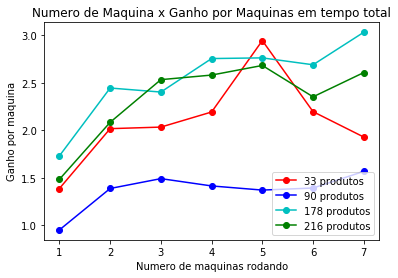

In [160]:
url1, = plt.plot(num_maq, tempo_total_por_maquina_url1, 'ro-', label='33 produtos')
url2, = plt.plot(num_maq, tempo_total_por_maquina_url2, 'bo-', label='90 produtos')
url3, = plt.plot(num_maq, tempo_total_por_maquina_url3, 'co-', label= '178 produtos')
url4, = plt.plot(num_maq, tempo_total_por_maquina_url4, 'go-', label= '216 produtos')
plt.xlabel('Numero de maquinas rodando')
plt.ylabel('Ganho por maquina')
plt.title("Numero de Maquina x Ganho por Maquinas em tempo total")
plt.legend(handles=[url1, url2, url3, url4])
plt.show()

Analisando as informações a cima é possível perceber que quanto mais máquinas, maior o ganho por maquinas, tanto em tempo total quanto em tempo médio por produto. A quantidade de produto por categoria não parece interferir nos ganhos por máquina.

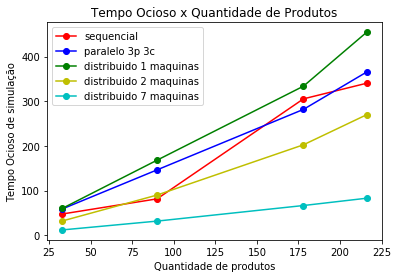

In [161]:
seq, = plt.plot(t_num_prod, t_ocioso_seq, 'ro-', label='sequencial')
par33, = plt.plot(t_num_prod, t_ocioso_par_3_3, 'bo-', label='paralelo 3p 3c')
dis1, = plt.plot(t_num_prod, t_ocioso_dis_1, 'go-', label= 'distribuido 1 maquinas')
dis2, = plt.plot(t_num_prod, t_ocioso_dis_2, 'yo-', label= 'distribuido 2 maquinas')
dis7, = plt.plot(t_num_prod, t_ocioso_dis_7, 'co-', label= 'distribuido 7 maquinas')
plt.xlabel('Quantidade de produtos')
plt.ylabel('Tempo Ocioso de simulação')
plt.title("Tempo Ocioso x Quantidade de Produtos")
plt.legend(handles=[seq, par33, dis1, dis2, dis7])
plt.show()

A partir do gráfico a cima é possível perceber que o tempo ocioso é pouco afetado pelos métodos de concorrência, ele se comporta do mesmo modo no três tipos de crawler

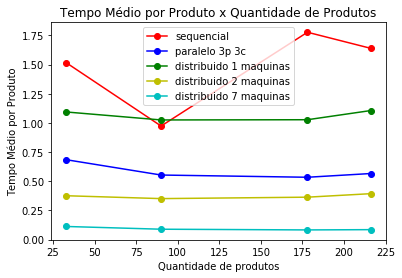

In [162]:
seq, = plt.plot(t_num_prod, t_medProd_seq, 'ro-', label='sequencial')
par33, = plt.plot(t_num_prod, t_medProd_par_3_3, 'bo-', label='paralelo 3p 3c')
dis1, = plt.plot(t_num_prod, t_medProd_dis_1, 'go-', label= 'distribuido 1 maquinas')
dis2, = plt.plot(t_num_prod, t_medProd_dis_2, 'yo-', label= 'distribuido 2 maquinas')
dis7, = plt.plot(t_num_prod, t_medProd_dis_7, 'co-', label= 'distribuido 7 maquinas')
plt.xlabel('Quantidade de produtos')
plt.xlabel('Quantidade de produtos')
plt.ylabel('Tempo Médio por Produto')
plt.title("Tempo Médio por Produto x Quantidade de Produtos")
plt.legend(handles=[seq, par33, dis1, dis2, dis7])
plt.show()

Pela análises a cima é possível perceber que normalmente o tempo médio por produto permanece estável independente do número total de produtos sendo processados.

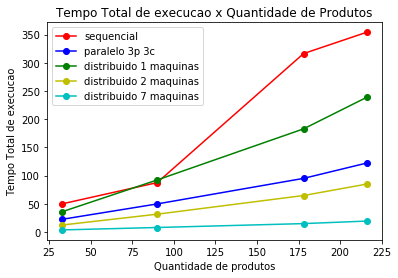

In [163]:
seq, = plt.plot(t_num_prod, t_total_seq, 'ro-', label='sequencial')
par33, = plt.plot(t_num_prod, t_total_par_3_3, 'bo-', label='paralelo 3p 3c')
dis1, = plt.plot(t_num_prod, t_total_dis_1, 'go-', label= 'distribuido 1 maquinas')
dis2, = plt.plot(t_num_prod, t_total_dis_2, 'yo-', label= 'distribuido 2 maquinas')
dis7, = plt.plot(t_num_prod, t_total_dis_7, 'co-', label= 'distribuido 7 maquinas')
plt.xlabel('Quantidade de produtos')
plt.ylabel('Tempo Total de execucao')
plt.title("Tempo Total de execucao x Quantidade de Produtos")
plt.legend(handles=[seq, par33, dis1, dis2, dis7])
plt.show()

In [164]:
seq_par33_total_media=0
seq_dis_1_total_media=0
seq_dis_7_total_media=0
dis_1_par33_total_media=0
par33_dis_7_total_media=0
count =0

for i in range (0, len(t_total_seq)):
    for i in range(0, len(t_total_par_3_3)):
        seq_par33_total_media = seq_par33_total_media + (t_total_seq[i]/t_total_par_3_3[i])
        seq_dis_1_total_media = seq_dis_1_total_media + (t_total_seq[i]/t_total_dis_1[i])
        seq_dis_7_total_media = seq_dis_7_total_media + (t_total_seq[i]/t_total_dis_7[i])
        dis_1_par33_total_media = dis_1_par33_total_media + (t_total_dis_1[i]/t_total_par_3_3[i])
        par33_dis_7_total_media = par33_dis_7_total_media + (t_total_par_3_3[i]/t_total_dis_7[i])
        count+=1
        
print("Média de ganho tempo total de paralelo (3 prod 3 cons) para seq= " + str(seq_par33_total_media/count))
print("Média de ganho tempo total de distribuido (1 maquina) para seq= " + str(seq_dis_1_total_media/count))
print("Média de ganho tempo total de distribuido (7 maquinas) para seq= " + str(seq_dis_7_total_media/count))
print("Média de ganho tempo total de paralelo (3 prod 3 cons) para distribuido (1 maquina)= " + str(dis_1_par33_total_media/count))
print("Média de ganho tempo total de distribuido (7 maquinas) para paralelo (3 prod 3 cons)= " + str(par33_dis_7_total_media/count))

Média de ganho tempo total de paralelo (3 prod 3 cons) para seq= 2.549296557890009
Média de ganho tempo total de distribuido (1 maquina) para seq= 1.3869063551633605
Média de ganho tempo total de distribuido (7 maquinas) para seq= 15.987819448884398
Média de ganho tempo total de paralelo (3 prod 3 cons) para distribuido (1 maquina)= 1.832015868915663
Média de ganho tempo total de distribuido (7 maquinas) para paralelo (3 prod 3 cons)= 6.253147838528595


Com as análises acima, percebe-se que tanto o crawler paralelo quanto o distribuido possuem ganhos significativos em relação ao sequencial. O paralelo é cerca de 2.54 vezes mais rápido que o sequencial enquanto o distribuido com 1 máquina (4 processos) é 1.38 vezes mais rápido que o sequencial. Tendo isso em vista, o paralelo com 3 threads produtoras e 3 threads consumidoras é mais rápido que o distribuido com 4 processos cerca de 1,83 vezes. No entanto, aumentanto apenas 1 máquina (total de 8 processos) o crawler distribuido se torna mais rápido que o crawler paralelo, como pode ser visto no gráfico a cima. Ao comparar o crawler distribuido mais eficiente disponivel (7 maquinas, 28 processos) com o sequencial, tem-se um ganho de quase 16 vezes, e ao compará-lo com o paralaleo 3p 3c esse distribuído é mais rápido que ele 6.25 vezes. 